### Comparing Scalene profiles for different worker counts

We run several repeats for each `--workers` value (layout `profile/full_optim/wN/runM/profile.json`), collect time/memory, and show averages plus spread (box plots).


In [13]:
import json
import re
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8')

PROFILE_ROOT = Path('profile/full_optim')
RUN_GLOB = 'w*'  # subfolders like w1, w2, ...


In [14]:
def extract_profile_metrics(path: Path) -> dict:
    data = json.loads(path.read_text())
    return {
        'elapsed_sec': data.get('elapsed_time_sec') or 0,
        'max_footprint_mb': data.get('max_footprint_mb') or 0,
    }


def extract_error_stats(run_dir: Path) -> dict:
    errors = None
    processed = None
    error_rate = None
    # No explicit error metrics in current data; keep placeholder
    return {'errors': errors, 'processed': processed, 'error_rate': error_rate}


def is_successful_run(metrics: dict, stats: dict, html_exists: bool) -> bool:
    if not html_exists:
        return False
    if not metrics['elapsed_sec'] or not metrics['max_footprint_mb']:
        return False
    if stats.get('processed') == 0:
        return False
    if stats.get('error_rate') is not None and stats['error_rate'] > 0:
        return False
    return True


def load_runs():
    rows = []
    for sub in sorted(PROFILE_ROOT.glob(RUN_GLOB), key=lambda p: int(p.name.lstrip('w') or 0)):
        # old format without run*/profile.json
        direct_profile = sub / 'profile.json'
        if direct_profile.exists():
            metrics = extract_profile_metrics(direct_profile)
            stats = extract_error_stats(sub)
            workers = int(sub.name.lstrip('w') or 0)
            html_exists = (sub / 'profile.html').exists()
            success = is_successful_run(metrics, stats, html_exists)
            rows.append({'workers': workers, 'run': 1, 'profile_path': str(direct_profile), 'success': success, **metrics, **stats})
        # new format: run*/profile.json
        for run_dir in sorted(sub.glob('run*'), key=lambda p: int(p.name.lstrip('run') or 0)):
            profile_path = run_dir / 'profile.json'
            if not profile_path.exists():
                continue
            metrics = extract_profile_metrics(profile_path)
            stats = extract_error_stats(run_dir)
            workers = int(sub.name.lstrip('w') or 0)
            run_num = int(run_dir.name.lstrip('run') or 0)
            html_exists = (run_dir / 'profile.html').exists()
            success = is_successful_run(metrics, stats, html_exists)
            rows.append({'workers': workers, 'run': run_num, 'profile_path': str(profile_path), 'success': success, **metrics, **stats})
    if not rows:
        return pd.DataFrame(columns=['workers', 'run', 'profile_path', 'elapsed_sec', 'max_footprint_mb', 'errors', 'processed', 'error_rate', 'success']).set_index('workers')
    return pd.DataFrame(rows).set_index('workers').sort_index()


df = load_runs()
failed = int((~df['success']).sum()) if not df.empty else 0
display(df)
if failed:
    print(f"Dropped {failed} runs due to missing html or zero metrics")
valid_df = df[df['success']].copy()
display(valid_df)

agg = (valid_df.reset_index().groupby('workers')
         .agg(elapsed_sec_mean=('elapsed_sec','mean'),
              elapsed_sec_median=('elapsed_sec','median'),
              elapsed_sec_std=('elapsed_sec','std'),
              max_footprint_mb_mean=('max_footprint_mb','mean'),
              max_footprint_mb_median=('max_footprint_mb','median'),
              max_footprint_mb_std=('max_footprint_mb','std'))
        ) if not valid_df.empty else pd.DataFrame()

run_errors = (df.reset_index().groupby('workers')
               .agg(run_error_rate=('success', lambda s: 1 - s.mean()),
                    failed_runs=('success', lambda s: int((~s).sum())),
                    total_runs=('success', 'count'))
              ) if not df.empty else pd.DataFrame()

display(agg)
display(run_errors)


,run,profile_path,success,elapsed_sec,max_footprint_mb,errors,processed,error_rate
workers,,,,,,,,
1,1,profile/full_optim/w1/run1/profile.json,True,3.687844,75.053482,None,None,None
1,2,profile/full_optim/w1/run2/profile.json,True,3.661513,73.856572,None,None,None
1,3,profile/full_optim/w1/run3/profile.json,True,3.776116,62.561570,None,None,None
1,4,profile/full_optim/w1/run4/profile.json,True,3.702382,84.846066,None,None,None
1,5,profile/full_optim/w1/run5/profile.json,True,3.743213,73.800344,None,None,None
...,...,...,...,...,...,...,...,...
14,6,profile/full_optim/w14/run6/profile.json,True,2.604111,247.737026,None,None,None
14,7,profile/full_optim/w14/run7/profile.json,True,2.792309,332.750510,None,None,None
14,8,profile/full_optim/w14/run8/profile.json,True,2.820421,310.658177,None,None,None


Dropped 2 runs due to missing html or zero metrics


,run,profile_path,success,elapsed_sec,max_footprint_mb,errors,processed,error_rate
workers,,,,,,,,
1,1,profile/full_optim/w1/run1/profile.json,True,3.687844,75.053482,None,None,None
1,2,profile/full_optim/w1/run2/profile.json,True,3.661513,73.856572,None,None,None
1,3,profile/full_optim/w1/run3/profile.json,True,3.776116,62.561570,None,None,None
1,4,profile/full_optim/w1/run4/profile.json,True,3.702382,84.846066,None,None,None
1,5,profile/full_optim/w1/run5/profile.json,True,3.743213,73.800344,None,None,None
...,...,...,...,...,...,...,...,...
14,6,profile/full_optim/w14/run6/profile.json,True,2.604111,247.737026,None,None,None
14,7,profile/full_optim/w14/run7/profile.json,True,2.792309,332.750510,None,None,None
14,8,profile/full_optim/w14/run8/profile.json,True,2.820421,310.658177,None,None,None


,elapsed_sec_mean,elapsed_sec_median,elapsed_sec_std,max_footprint_mb_mean,max_footprint_mb_median,max_footprint_mb_std
workers,,,,,,
1,3.764032,3.755939,0.098953,78.536385,74.455027,9.477085
2,2.968171,2.954676,0.128893,99.710637,97.616648,9.034834
3,2.769917,2.752224,0.084327,118.718445,120.103673,16.799851
4,2.679038,2.646765,0.149364,124.248910,123.380505,16.474964
5,2.694433,2.666508,0.103912,142.314102,139.522769,22.005910
6,2.710626,2.679817,0.147855,166.921132,159.731502,26.792975
7,2.717559,2.708429,0.168928,182.638830,182.922624,25.954377
8,2.802776,2.737797,0.244656,205.640052,197.121668,29.511592
9,2.738384,2.743076,0.174724,213.953786,190.965638,49.438578


,run_error_rate,failed_runs,total_runs
workers,,,
1,0.0,0,10
2,0.0,0,10
3,0.0,0,10
4,0.0,0,10
5,0.0,0,10
6,0.0,0,10
7,0.0,0,10
8,0.0,0,10
9,0.0,0,10


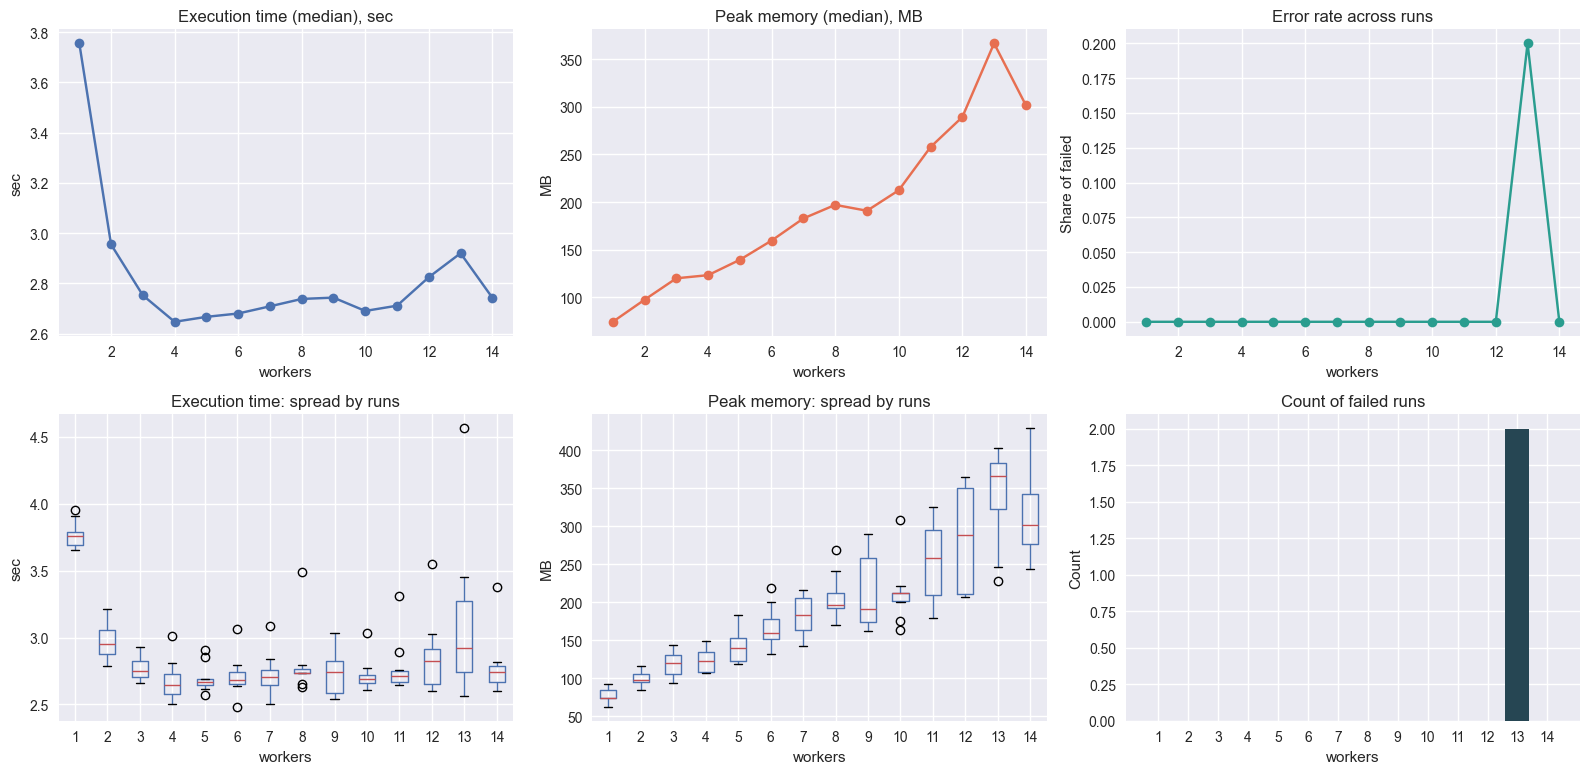

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

if df.empty:
    print('No data: make sure profiles are in profile/full_optim/w*/run*/profile.json')
    plt.close(fig)
else:
    error_series = run_errors['run_error_rate'] if not run_errors.empty else None
    failed_counts = run_errors['failed_runs'] if not run_errors.empty else None
    if not agg.empty:
        agg['elapsed_sec_median'].plot(ax=axes[0, 0], marker='o')
        axes[0, 0].set_title('Execution time (median), sec')
        axes[0, 0].set_ylabel('sec')
        axes[0, 0].set_xlabel('workers')
        agg['max_footprint_mb_median'].plot(ax=axes[0, 1], marker='o', color='#e76f51')
        axes[0, 1].set_title('Peak memory (median), MB')
        axes[0, 1].set_ylabel('MB')
        axes[0, 1].set_xlabel('workers')
    else:
        valid_df['elapsed_sec'].plot(ax=axes[0, 0], marker='o')
        axes[0, 0].set_title('Execution time, sec')
        valid_df['max_footprint_mb'].plot(ax=axes[0, 1], marker='o', color='#e76f51')
        axes[0, 1].set_title('Peak memory, MB')

    if error_series is not None and not error_series.empty:
        error_series.plot(ax=axes[0, 2], marker='o', color='#2a9d8f')
        axes[0, 2].set_title('Error rate across runs')
        axes[0, 2].set_ylabel('Share of failed')
        axes[0, 2].set_xlabel('workers')
    else:
        axes[0, 2].set_title('Error rate (no data)')
        axes[0, 2].text(0.5, 0.5, 'No error info', ha='center', va='center')
        axes[0, 2].set_xticks([])
        axes[0, 2].set_yticks([])

    valid_df.boxplot(column='elapsed_sec', by='workers', ax=axes[1, 0])
    axes[1, 0].set_title('Execution time: spread by runs')
    axes[1, 0].set_ylabel('sec')
    axes[1, 0].set_xlabel('workers')
    valid_df.boxplot(column='max_footprint_mb', by='workers', ax=axes[1, 1])
    axes[1, 1].set_title('Peak memory: spread by runs')
    axes[1, 1].set_ylabel('MB')
    axes[1, 1].set_xlabel('workers')

    if failed_counts is not None and not failed_counts.empty:
        axes[1, 2].bar(failed_counts.index.astype(str), failed_counts, color='#264653')
        axes[1, 2].set_title('Count of failed runs')
        axes[1, 2].set_ylabel('Count')
        axes[1, 2].set_xlabel('workers')
    else:
        axes[1, 2].set_title('Failed runs: no data')
        axes[1, 2].set_xticks([])
        axes[1, 2].set_yticks([])

    plt.suptitle('')
    plt.tight_layout()
    plt.show()


In [16]:
if valid_df.empty:
    print('No data for summary (all runs filtered out)')
elif not agg.empty:
    best_time_w = agg['elapsed_sec_median'].idxmin()
    best_mem_w = agg['max_footprint_mb_median'].idxmin()
    print(f"Best median time: {best_time_w} worker(s) -> {agg.loc[best_time_w, 'elapsed_sec_median']:.3f} sec")
    print(f"Best median memory: {best_mem_w} worker(s) -> {agg.loc[best_mem_w, 'max_footprint_mb_median']:.1f} MB")
    if not run_errors.empty:
        best_err_w = run_errors['run_error_rate'].idxmin()
        print(f"Lowest error rate across runs: {best_err_w} worker(s) -> {run_errors.loc[best_err_w, 'run_error_rate']:.4f}")
else:
    print('Not enough data for aggregation')


Best median time: 4 worker(s) -> 2.647 sec
Best median memory: 1 worker(s) -> 74.5 MB
Lowest error rate across runs: 1 worker(s) -> 0.0000
